# Navigation Control B - Analyses

# Analyses

In [1]:
from scipy import stats 
from functools import lru_cache
import json
import pandas as pd
import seaborn as sns
from msdm.domains import GridWorld
from vgc_project import gridutils, utils

In [2]:
survey_trials = pd.DataFrame(json.load(open("./data/all-survey-trials.json", 'r')))
attn_trials = pd.DataFrame(json.load(open("./data/all-attention-trials.json", 'r')))
mem_trials = pd.DataFrame(json.load(open("./data/all-memory-trials.json", 'r')))
bc_trials = pd.DataFrame(json.load(open("./data/all-nav-trials.json", 'r')))

#apply exclusions
survey_trials = survey_trials[~survey_trials.exclude].reset_index(drop=True)
attn_trials = attn_trials[~attn_trials['exclude_trial'] & attn_trials.sessionId.isin(survey_trials.sessionId)].reset_index(drop=True)
mem_trials = mem_trials[~mem_trials['exclude_trial'] & mem_trials.sessionId.isin(survey_trials.sessionId)].reset_index(drop=True)
bc_trials = bc_trials[~bc_trials['exclude_trial'] & bc_trials.sessionId.isin(survey_trials.sessionId)].reset_index(drop=True)

## Compare with Experiment 3

In [3]:
EXP3_NAV_FILE = "../../experiments/exp3/data/results/navtrials.json"
EXP3_ATTN_FILE = "../../experiments/exp3/data/results/attentiontrials.json"
EXP3_MEM_FILE = "../../experiments/exp3/data/results/memorytrials.json"
exp3_at = pd.DataFrame(json.load(open(EXP3_ATTN_FILE, 'r')))
exp3_mt = pd.DataFrame(json.load(open(EXP3_MEM_FILE, 'r')))
exp3_nt = pd.DataFrame(json.load(open(EXP3_NAV_FILE, 'r')))

crit_obs = json.load(open("../mazes/mazes_12-15_crit_obs.json"))
basegrids = json.load(open("../mazes/mazes_12-15.json", 'r'))

In [4]:
# get navdist matrics
@lru_cache()
def make_gridworld(tile_array):
    return GridWorld(tile_array)

def calc_obs_traj_dist(grid, obs, traj):
    obs_locs = make_gridworld(tuple(basegrids[grid])).feature_locations[obs]
    return gridutils.min_dist(obs_locs, traj)["mindist"]

def calc_nav_dist_exp3(row):
    grid = row.grid
    res = {}
    traj = [tuple(t) for t in row.traj]
    for obs in "0123456789":
        try:
            res[obs] = calc_obs_traj_dist(grid, obs, traj)
        except KeyError:
            continue
    return pd.Series(res)
    
exp6b_nav_dist = pd.concat([
    attn_trials[['grid', 'obstacle', 'nav_mindist']],
    mem_trials[['grid', 'obstacle', 'nav_mindist']],
]).reset_index(drop=True)
exp3_nt['grid'] = exp3_nt['grid'].apply(lambda g: "grid-" + str(g))
exp3_trajs = exp3_nt.groupby(['round', 'grid', 'sessionId']).apply(lambda rs: pd.Series({"traj": list(rs.sort_values('trialnum')['state'])})).reset_index()
exp3_nav_dist = exp3_trajs.apply(calc_nav_dist_exp3, axis=1)
exp3_nav_dist = \
    pd.concat([exp3_trajs[['sessionId', 'grid', 'round']], exp3_nav_dist], axis=1).\
    melt(id_vars=['sessionId', 'grid', 'round'], var_name="obstacle", value_name="nav_mindist")

In [5]:
#check that the mean navdists are almost the same
from scipy.stats import pearsonr
nav_mindists = pd.concat([
    exp6b_nav_dist.groupby(['grid', 'obstacle'])['nav_mindist'].mean(),
    exp3_nav_dist.groupby(['grid', 'obstacle'])['nav_mindist'].mean()
], axis=1)
nav_mindists.columns = ['exp6b', 'exp3']
assert .99 < pearsonr(nav_mindists.exp6b, nav_mindists.exp3)[0] < 1.0

<AxesSubplot:xlabel='exp6b', ylabel='exp3'>

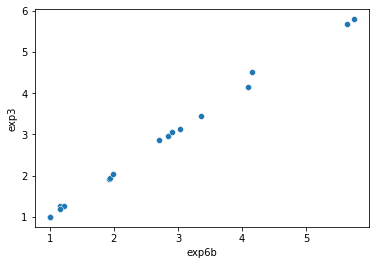

In [6]:
sns.scatterplot(data=nav_mindists, x='exp6b', y='exp3')

In [7]:
#combine memory with navdists
# scale confidence back to 1 - 8
x = exp3_mt['conf'].values
x[x > 0] = x[x > 0] - 1
exp3_mt['conf'] = x + 5

# do other alignment things
exp3_mt = exp3_mt.rename(columns={'probeobs': 'obstacle'})
exp3_mt.obstacle = exp3_mt.obstacle.apply(str)
exp3_mt.grid = exp3_mt.grid.apply(lambda g: "grid-"+str(g))

exp6b_mt = mem_trials[['round', 'grid', 'obstacle','sessionId', 'correct', 'conf']].reset_index(drop=True)
exp6b_mt['obstacle'] = exp6b_mt['obstacle'].apply(str)

exp3_mt = exp3_mt[['round', 'grid', 'obstacle','sessionId', 'correct', 'conf']].reset_index(drop=True)
exp3_mt = exp3_mt.merge(exp3_nav_dist, on=['sessionId', 'round', 'grid', 'obstacle'])

#check that they have same "support"
assert set(exp3_mt['conf'].unique()) == set(exp6b_mt['conf'].unique())
assert set(exp3_mt['obstacle'].unique()) == set(exp6b_mt['obstacle'].unique())
assert set(exp3_mt['grid'].unique()) == set(exp6b_mt['grid'].unique())

In [8]:
#combine attention w navdists
exp3_at['obstacle'] = exp3_at['probeobs']
exp3_at.grid = exp3_at.grid.apply(lambda g: "grid-"+str(g))
exp3_at = exp3_at[['round', 'grid', 'obstacle', 'sessionId', 'attention']].reset_index(drop=True)
exp3_at['obstacle'] = exp3_at['obstacle'].apply(str)
exp3_at = exp3_at.merge(exp3_nav_dist, on=['sessionId', 'round', 'grid', 'obstacle'])

#scale
x = exp3_at['attention'].values
x[x > 0] = x[x > 0] - 1
exp3_at['attention'] = x + 5

exp6b_at = attn_trials[['round', 'grid', 'obstacle','sessionId', 'attn_resp']].rename(columns={'attn_resp':'attention'}).reset_index(drop=True)
exp6b_at['obstacle'] = exp6b_at['obstacle'].apply(str)

#check that they have same "support"
assert set(exp3_at['attention'].unique()) == set(exp6b_at['attention'].unique())
assert set(exp3_at['obstacle'].unique()) == set(exp6b_at['obstacle'].unique())
assert set(exp3_at['grid'].unique()) == set(exp6b_at['grid'].unique())

In [9]:
# combine memory into a single dataframe
comp_mt = pd.concat([
    exp3_mt.assign(exp="exp3"),
    exp6b_mt.assign(exp="exp6b")
]).reset_index(drop=True)
comp_mt['crit_obs'] = comp_mt.apply(lambda r: crit_obs[r.grid.replace("grid", "gridB")+"-0"][r.obstacle], axis=1)
comp_mt['conf_N'] = utils.normalize(comp_mt['conf'])

# combine attn into a single dataframe
comp_at = pd.concat([
    exp3_at.assign(exp="exp3"),
    exp6b_at.assign(exp="exp6b")
]).reset_index(drop=True)
comp_at['crit_obs'] = comp_at.apply(lambda r: crit_obs[r.grid.replace("grid", "gridB")+"-0"][r.obstacle], axis=1)
comp_at['attention_N'] = utils.normalize(comp_at['attention'])

In [10]:
from vgc_project.modelinterface import create_modeling_interface
from vgc_project import utils
mods = create_modeling_interface(joblib_cache_location="../../experiments/_analysiscache")

model_preds = []
for _, (gn, obs) in comp_at[['grid', 'obstacle']].iterrows():
    model_preds.append(mods.predictions(tuple(basegrids[gn]), obs, seed=72193880))
    
comp_at = pd.concat([
    comp_at,
    pd.DataFrame(model_preds)
], axis=1)
comp_at['neg_nav_mindist'] = -comp_at['nav_mindist']

model_preds = []
for _, (gn, obs) in comp_mt[['grid', 'obstacle']].iterrows():
    model_preds.append(mods.predictions(tuple(basegrids[gn]), obs, seed=72193880))
    
comp_mt = pd.concat([
    comp_mt,
    pd.DataFrame(model_preds)
], axis=1)
comp_mt['neg_nav_mindist'] = -comp_mt['nav_mindist']

to_zscore = [
    'vgc_weight',
    'value_mix_weight',
    'graph_based_hitcount',
    'goal_dist',
    'start_dist',
    'optpolicy_dist',
    'walls_dist',
    'center_dist',
    'bottleneck_dist',
    'sr_occ',
    'log_traj_based_hitcount',
    'nav_mindist',
    'neg_nav_mindist'
]
for col in to_zscore:
    comp_at[col+"_Z"] = utils.zscore(comp_at[col])
    comp_mt[col+"_Z"] = utils.zscore(comp_mt[col])

In [11]:
%load_ext rpy2.ipython

In [12]:
%%R
library(lme4)
library(lmerTest)

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [13]:
%%R -i comp_at,comp_mt
# use sum coding for experiment comparison
comp_at$exp <- factor(comp_at$exp)
contrasts(comp_at$exp) <- contr.sum(2)
print(contrasts(comp_at$exp))

comp_mt$exp <- factor(comp_mt$exp)
contrasts(comp_mt$exp) <- contr.sum(2)
print(contrasts(comp_mt$exp))

      [,1]
exp3     1
exp6b   -1
      [,1]
exp3     1
exp6b   -1


In [14]:
%%R
full <- glmer(
    correct ~ (1 | sessionId) + exp*vgc_weight_Z,
    control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=1e+07)),
    data=comp_mt[comp_mt$crit_obs %in% c("rel", "irrel"), ],
    family=binomial
)
print(anova(
    update(full, ~ . - exp:vgc_weight_Z),
    full
))
summary(full)

Data: comp_mt[comp_mt$crit_obs %in% c("rel", "irrel"), ]
Models:
update(full, ~. - exp:vgc_weight_Z): correct ~ (1 | sessionId) + exp + vgc_weight_Z
full: correct ~ (1 | sessionId) + exp * vgc_weight_Z
                                    Df    AIC    BIC  logLik deviance  Chisq
update(full, ~. - exp:vgc_weight_Z)  4 5004.0 5028.9 -2498.0   4996.0       
full                                 5 4977.7 5008.8 -2483.9   4967.7 28.325
                                    Chi Df Pr(>Chisq)    
update(full, ~. - exp:vgc_weight_Z)                      
full                                     1  1.026e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: correct ~ (1 | sessionId) + exp * vgc_weight_Z
   Data: comp_mt[comp_mt$crit_obs %in% c("rel", "irrel"), ]
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+07))

     AIC  

In [15]:
%%R
full <- glmer(
    correct ~ (1 | sessionId) + exp*vgc_weight_Z,
    control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=1e+07)),
    data=comp_mt,
    family=binomial
)
print(anova(
    update(full, ~ . - exp:vgc_weight_Z),
    full
))
summary(full)

Data: comp_mt
Models:
update(full, ~. - exp:vgc_weight_Z): correct ~ (1 | sessionId) + exp + vgc_weight_Z
full: correct ~ (1 | sessionId) + exp * vgc_weight_Z
                                    Df    AIC    BIC  logLik deviance  Chisq
update(full, ~. - exp:vgc_weight_Z)  4 7734.5 7761.4 -3863.2   7726.5       
full                                 5 7676.6 7710.3 -3833.3   7666.6 59.854
                                    Chi Df Pr(>Chisq)    
update(full, ~. - exp:vgc_weight_Z)                      
full                                     1  1.022e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: correct ~ (1 | sessionId) + exp * vgc_weight_Z
   Data: comp_mt
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+07))

     AIC      BIC   logLik deviance df.resid 
  7676.6   7710.3  -3833.3   7666.6     6165 

Sca

In [16]:
%%R
full <- lmer(
    conf_N ~ (1 | sessionId) + exp*vgc_weight_Z,
    control=lmerControl(optimizer="bobyqa",optCtrl=list(maxfun=1e+07)),
    data=comp_mt,
    REML=F
)
print(anova(
    update(full, ~ . - exp:vgc_weight_Z),
    full
))
summary(full)

Data: comp_mt
Models:
update(full, ~. - exp:vgc_weight_Z): conf_N ~ (1 | sessionId) + exp + vgc_weight_Z
full: conf_N ~ (1 | sessionId) + exp * vgc_weight_Z
                                    Df    AIC    BIC  logLik deviance  Chisq
update(full, ~. - exp:vgc_weight_Z)  5 571.75 605.38 -280.87   561.75       
full                                 6 512.43 552.80 -250.22   500.43 61.314
                                    Chi Df Pr(>Chisq)    
update(full, ~. - exp:vgc_weight_Z)                      
full                                     1  4.867e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: conf_N ~ (1 | sessionId) + exp * vgc_weight_Z
   Data: comp_mt
Control: lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+07))

     AIC      BIC   logLik deviance df.resid 
   512.4    552.8   -250.2    500.4     6164 

Scaled residuals: 
    Min  

In [17]:
%%R
full <- lmer(
    attention_N ~ (1 | sessionId) + exp*vgc_weight_Z,
    control=lmerControl(optimizer="bobyqa",optCtrl=list(maxfun=1e+07)),
    data=comp_at,
    REML=F
)
print(anova(
    update(full, ~ . - exp:vgc_weight_Z),
    full
))
summary(full)

Data: comp_at
Models:
update(full, ~. - exp:vgc_weight_Z): attention_N ~ (1 | sessionId) + exp + vgc_weight_Z
full: attention_N ~ (1 | sessionId) + exp * vgc_weight_Z
                                    Df    AIC    BIC  logLik deviance  Chisq
update(full, ~. - exp:vgc_weight_Z)  5 2473.7 2507.4 -1231.8   2463.7       
full                                 6 2374.8 2415.2 -1181.4   2362.8 100.93
                                    Chi Df Pr(>Chisq)    
update(full, ~. - exp:vgc_weight_Z)                      
full                                     1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: attention_N ~ (1 | sessionId) + exp * vgc_weight_Z
   Data: comp_at
Control: lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+07))

     AIC      BIC   logLik deviance df.resid 
  2374.8   2415.2  -1181.4   2362.8     6279 

Scaled residu

In [18]:
%%R
full <- glmer(
    correct ~ (1 + round | sessionId) + (1 | grid) + 
        exp*(
            vgc_weight_Z + 
            graph_based_hitcount_Z + 
            log_traj_based_hitcount_Z + 
            goal_dist_Z + 
            start_dist_Z + 
            walls_dist_Z + 
            center_dist_Z + 
            bottleneck_dist_Z + 
            sr_occ_Z + 
            neg_nav_mindist_Z
        )
    ,
    data=comp_mt,
    control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=1e+07)),
    family=binomial
)
lesioned <- update(full, ~ . - exp:vgc_weight_Z)
print(anova(
    lesioned,
    full
))
summary(full)

R[write to console]: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]) : 
  contrasts can be applied only to factors with 2 or more levels

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: contrasts dropped from factor exp due to missing levels 

R[write to console]: 2: contrasts dropped from factor exp due to missing levels 




Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]) : 
  contrasts can be applied only to factors with 2 or more levels


In [46]:
%%R
full <- lmer(
    conf_N ~ (1 + round | sessionId) + (1 | grid) + 
        exp*(
            vgc_weight_Z + 
            graph_based_hitcount_Z + 
            log_traj_based_hitcount_Z + 
            goal_dist_Z + 
            start_dist_Z + 
            walls_dist_Z + 
            center_dist_Z + 
            bottleneck_dist_Z + 
            sr_occ_Z + 
            neg_nav_mindist_Z
        )
    ,
    data=comp_mt,
    control=lmerControl(optimizer="bobyqa",optCtrl=list(maxfun=1e+07)),
    REML=F
)
lesioned <- update(full, ~ . - exp:vgc_weight_Z)
print(anova(
    lesioned,
    full
))
summary(full)

Data: comp_mt
Models:
lesioned: conf_N ~ (1 + round | sessionId) + (1 | grid) + exp + vgc_weight_Z + 
lesioned:     graph_based_hitcount_Z + log_traj_based_hitcount_Z + goal_dist_Z + 
lesioned:     start_dist_Z + walls_dist_Z + center_dist_Z + bottleneck_dist_Z + 
lesioned:     sr_occ_Z + neg_nav_mindist_Z + exp:graph_based_hitcount_Z + 
lesioned:     exp:log_traj_based_hitcount_Z + exp:goal_dist_Z + exp:start_dist_Z + 
lesioned:     exp:walls_dist_Z + exp:center_dist_Z + exp:bottleneck_dist_Z + 
lesioned:     exp:sr_occ_Z + exp:neg_nav_mindist_Z
full: conf_N ~ (1 + round | sessionId) + (1 | grid) + exp * (vgc_weight_Z + 
full:     graph_based_hitcount_Z + log_traj_based_hitcount_Z + goal_dist_Z + 
full:     start_dist_Z + walls_dist_Z + center_dist_Z + bottleneck_dist_Z + 
full:     sr_occ_Z + neg_nav_mindist_Z)
         Df      AIC    BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
lesioned 26   2.5373 177.45 24.731  -49.463                             
full     27 -25.9981 155.64 3

R[write to console]: 
Correlation matrix not shown by default, as p = 22 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [47]:
%%R
full <- lmer(
    attention_N ~ (1 + round | sessionId) + (1 | grid) + 
        exp*(
            vgc_weight_Z + 
            graph_based_hitcount_Z + 
            log_traj_based_hitcount_Z + 
            goal_dist_Z + 
            start_dist_Z + 
            walls_dist_Z + 
            center_dist_Z + 
            bottleneck_dist_Z + 
            sr_occ_Z + 
            neg_nav_mindist_Z
        )
    ,
    data=comp_at,
    control=lmerControl(optimizer="bobyqa",optCtrl=list(maxfun=1e+07)),
    REML=F
)
lesioned <- update(full, ~ . - exp:vgc_weight_Z)
print(anova(
    lesioned,
    full
))
summary(full)

Data: comp_at
Models:
lesioned: attention_N ~ (1 + round | sessionId) + (1 | grid) + exp + vgc_weight_Z + 
lesioned:     graph_based_hitcount_Z + log_traj_based_hitcount_Z + goal_dist_Z + 
lesioned:     start_dist_Z + walls_dist_Z + center_dist_Z + bottleneck_dist_Z + 
lesioned:     sr_occ_Z + neg_nav_mindist_Z + exp:graph_based_hitcount_Z + 
lesioned:     exp:log_traj_based_hitcount_Z + exp:goal_dist_Z + exp:start_dist_Z + 
lesioned:     exp:walls_dist_Z + exp:center_dist_Z + exp:bottleneck_dist_Z + 
lesioned:     exp:sr_occ_Z + exp:neg_nav_mindist_Z
full: attention_N ~ (1 + round | sessionId) + (1 | grid) + exp * (vgc_weight_Z + 
full:     graph_based_hitcount_Z + log_traj_based_hitcount_Z + goal_dist_Z + 
full:     start_dist_Z + walls_dist_Z + center_dist_Z + bottleneck_dist_Z + 
full:     sr_occ_Z + neg_nav_mindist_Z)
         Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
lesioned 26 809.91 985.31 -378.96   757.91                             
full     27 771.14 95

R[write to console]: 
Correlation matrix not shown by default, as p = 22 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




# Visualizations

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb

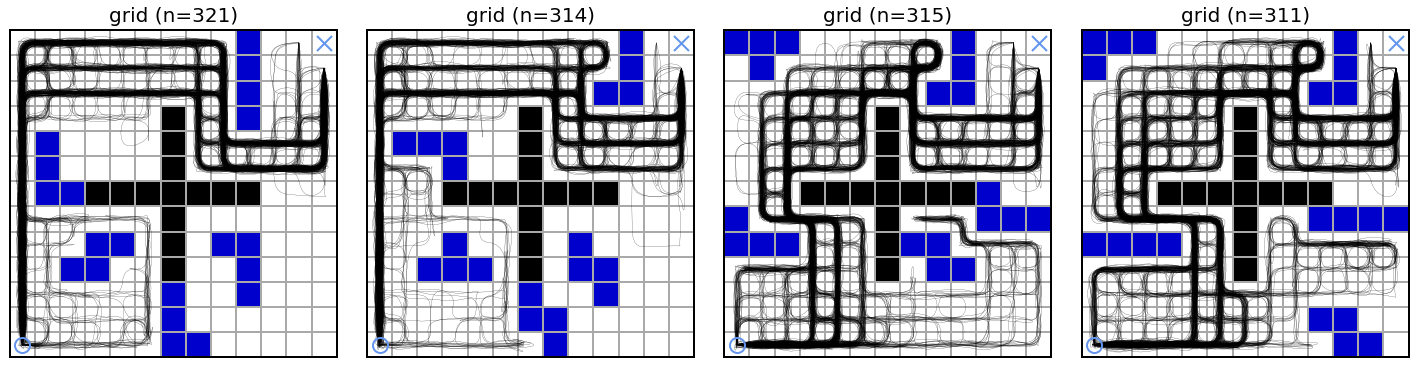

In [49]:
n_grids = len(bc_trials.grid.unique())
nrows = 1
ncols = n_grids // nrows
mult = 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*mult, nrows*mult))
axes = list(axes.flatten())
for grid, rows in bc_trials.groupby("grid"):
    gw = GridWorld(
        tile_array=basegrids[grid],
        absorbing_features="G",
        initial_features="S"
    )
    ax = axes.pop(0)
    gwp = gw.plot(ax=ax, featurecolors={**{f: "mediumblue" for f in "0123456789"}, "#": "k"})
    for _, row in rows.iterrows():
        gwp.plot_trajectory([t['state'] for t in row.navigationData], lw=.2)
    gwp.title(f"grid (n={len(rows)})", fontsize=20)
plt.tight_layout()

In [50]:
mediumblue = np.array(to_rgb('mediumblue'))
gainsboro = np.array(to_rgb('gainsboro'))

def color_mix(v, alpha=12):
    w = 1/(1 + np.exp(-alpha*(v-.5)))
    return (1-w)*gainsboro + w*mediumblue

def plot_obstacle_values(tile_array, values, ax, title,
                         vmin=0, vmax=1, invert=False,
                         show_numbers=False, number_fontsize=15, number_format="f"):
    fc = {o: color_mix((v - vmin)/(vmax - vmin)) for o, v in values.items()}
    gw = GridWorld(tile_array, absorbing_features=('G', ), initial_features=('S',))
    start = gw.initial_states[0]
    goal = gw.absorbing_states[0]
    gwp = gw.plot(featurecolors=fc, ax=ax, plot_initial_states=False, plot_absorbing_states=False).\
        annotate(start, text="S", fontsize=30, fontfamily="Courier New", weight='bold').\
        annotate(goal, text="G", fontsize=30, fontfamily="Courier New", weight='bold')
    if show_numbers:
        marked = []
        for loc, f in gw.location_features.items():
            if (f in fc) and (f not in marked):
                marked.append(f)
                if number_format == 'f':
                    if 0 < values[f] < 1.0:
                        text = f"{values[f]:.2f}".lstrip("0")
                    else: 
                        text = f"{values[f]:.1f}"
                elif number_format == 'g':
                    text = ("%.2g" % values[f]).replace("-0","-").lstrip("0")
                gwp.annotate(loc, 
                             text=text,
                             fontsize=number_fontsize,
                             weight='bold',
                             color='w' if ((values[f] - vmin)/(vmax - vmin)) > .5 else 'k')
        
    if title:
        gwp.title(f"{title}", fontsize=30)

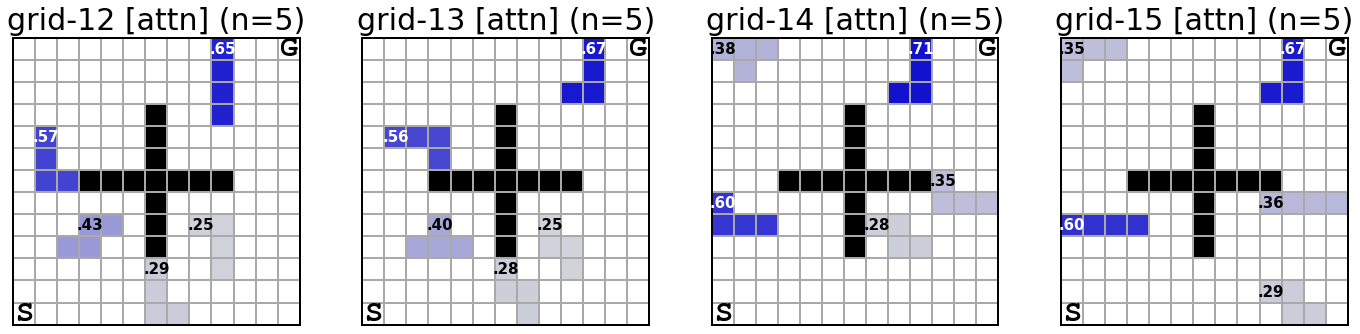

In [51]:
to_plot = attn_trials.groupby(['grid', 'obstacle'])['attn_resp_N'].agg(['mean', 'sem', 'count']).reset_index()
nrows = 1
ncols = 4
mul=6
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*mul, nrows*mul))
axes = list(axes.flatten())
for grid, rows in to_plot.groupby('grid'):
    tile_array = basegrids[grid]
    values = dict(zip([str(o) for o in rows.obstacle.values], rows['mean'].values))
    ax = axes.pop(0)
    title = f"{grid} [attn] (n={len(rows)})"
    plot_obstacle_values(tile_array, values, ax, title,
                         vmin=0, vmax=1, invert=False,
                         show_numbers=True, number_fontsize=15, number_format="f")

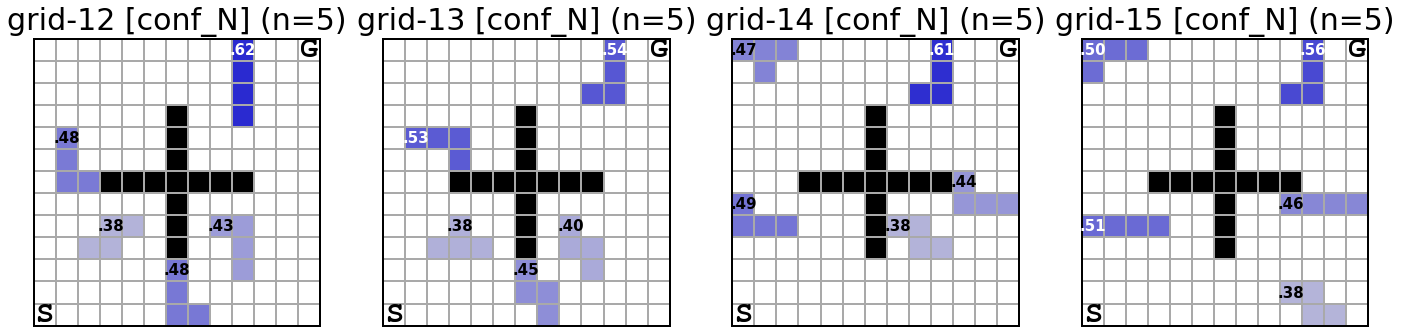

In [52]:
to_plot = mem_trials.groupby(['grid', 'obstacle'])['conf_N'].agg(['mean', 'sem', 'count']).reset_index()
nrows = 1
ncols = 4
mul=6
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*mul, nrows*mul))
axes = list(axes.flatten())
for grid, rows in to_plot.groupby('grid'):
    tile_array = basegrids[grid]
    values = dict(zip([str(o) for o in rows.obstacle.values], rows['mean'].values))
    ax = axes.pop(0)
    title = f"{grid} [conf_N] (n={len(rows)})"
    plot_obstacle_values(tile_array, values, ax, title,
                         vmin=0, vmax=1, invert=False,
                         show_numbers=True, number_fontsize=15, number_format="f")

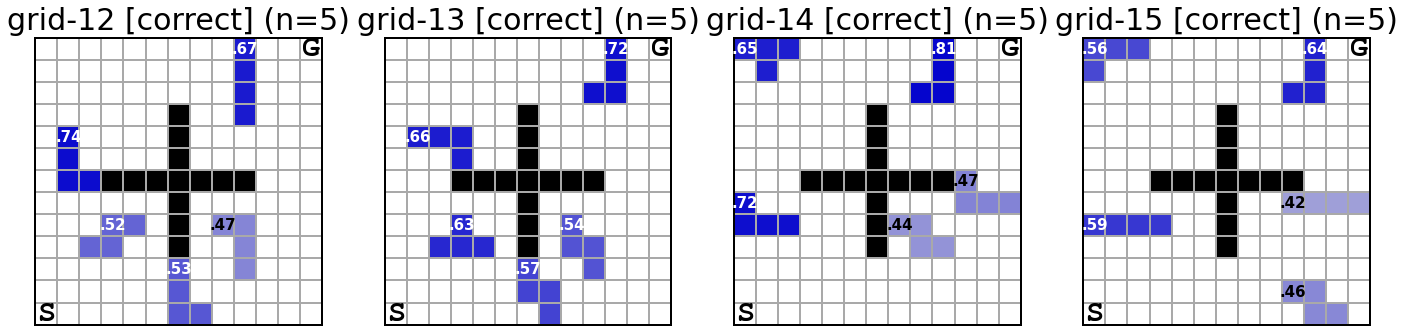

In [53]:
to_plot = mem_trials.groupby(['grid', 'obstacle'])['correct'].agg(['mean', 'sem', 'count']).reset_index()
nrows = 1
ncols = 4
mul=6
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*mul, nrows*mul))
axes = list(axes.flatten())
for grid, rows in to_plot.groupby('grid'):
    tile_array = basegrids[grid]
    values = dict(zip([str(o) for o in rows.obstacle.values], rows['mean'].values))
    ax = axes.pop(0)
    title = f"{grid} [correct] (n={len(rows)})"
    plot_obstacle_values(tile_array, values, ax, title,
                         vmin=0, vmax=1, invert=False,
                         show_numbers=True, number_fontsize=15, number_format="f")

Text(0.5, 1.0, 'Execution Control B')

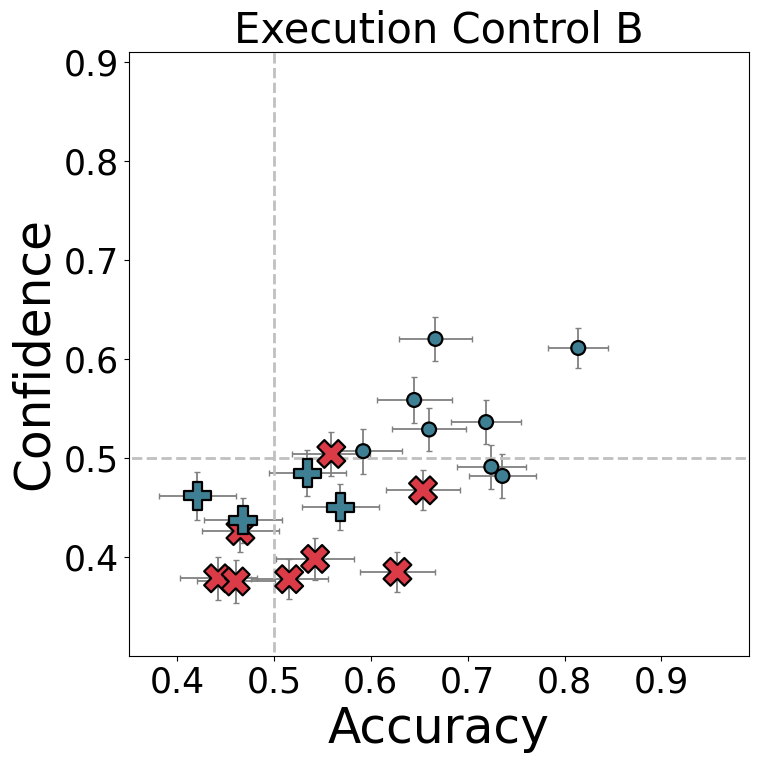

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def bin_sem(v):
    return np.sqrt(np.mean(v)*(1-np.mean(v))/len(v))
fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=100)
to_plot = pd.concat([
    comp_mt[comp_mt['exp'] == "exp6b"].groupby(['grid', 'obstacle'])[['correct', 'conf_N']].mean(),
    comp_mt[comp_mt['exp'] == "exp6b"].groupby(['grid', 'obstacle'])['vgc_weight'].mean(),
    comp_mt[comp_mt['exp'] == "exp6b"].groupby(['grid', 'obstacle'])['crit_obs'].apply(lambda rs: rs.iloc[0])
], axis=1)
to_plot_err = pd.concat([
    comp_mt[comp_mt['exp'] == "exp6b"].groupby(['grid', 'obstacle'])['correct'].agg(bin_sem).rename("correct_sem"),
    comp_mt[comp_mt['exp'] == "exp6b"].groupby(['grid', 'obstacle'])['conf_N'].sem().rename("conf_N_sem"),
], axis=1)
plt.errorbar(
    x=to_plot['correct'], y=to_plot['conf_N'],
    xerr=to_plot_err['correct_sem'], yerr=to_plot_err['conf_N_sem'], 
    fmt='none',
    ecolor='grey', 
    zorder=-1,
    capsize=2,
    linewidth=1.3
)
cmap = sns.diverging_palette(10, 220, as_cmap=True)
plt.plot([.5, .5], [.2, 1.0], color='silver', linestyle='--', zorder=-1, linewidth=2)
plt.plot([.2, 1.0], [.5, .5], color='silver', linestyle='--', zorder=-1, linewidth=2)
g = sns.scatterplot(data=to_plot, 
                    x='correct', y='conf_N', hue='vgc_weight', style='crit_obs',
                    markers={'irrel': 'X', 'rel': 'P', 'none': '.'},
                    palette=cmap, ec='k',
                    ax=ax, 
                    s=400,
                    hue_norm=(0, 1),
                   )
plt.ylim(.3, .91)
plt.xlim(.35, .99)

g.set_xlabel("Accuracy", fontsize=35)
g.set_ylabel("Confidence", fontsize=35)
g.set_xticks([.4, .5, .6, .7, .8, .9])
g.set_yticks([.4, .5, .6, .7, .8, .9])
g.tick_params(axis='y', labelsize=25)
g.tick_params(axis='x', labelsize=25)
g.legend_.remove()
g.set_title("Execution Control B", fontsize=30)